In [19]:
import random

import numpy as np
from enum import Enum

Methods = Enum('Methods', ['Classic', 'Momentum', 'AdaGrad', 'RMSprop', 'Adam', 'Nesterov'])
Regularization = Enum('Regularization', ['WithoutRegularization', 'L1', 'L2', 'Elastic'])
LearningRate = Enum('LearningRate', ['Const', 'Dichotomy'])
LearningRateScheduling = Enum('LearningRateScheduling', ['Classic', 'Stepwise', 'Exponential'])


def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1


class LinearRegression:
    def __init__(self, T, W, X, Y, regularization=Regularization.WithoutRegularization, l1=0.1, l2=0.1):
        self.T = np.array([T[i % len(T)](X[i // len(T)]) for i in range(len(T) * len(X))]).reshape(len(X), len(T))
        self.W = W
        self.X = X
        self.Y = Y
        self.regularization = regularization
        self.l1 = l1
        self.l2 = l2
        self.W_points = [np.copy(self.W)]
        self.loss_values = [self.loss(self.W)]

    def loss(self, W_Arg):
        val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
        match self.regularization:
            case Regularization.L1:
                val += self.l1 * sum([abs(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                val += self.l2 * sum([w ** 2 for w in self.W]) / len(self.W)
            case Regularization.Elastic:
                val += (self.l1 * sum([abs(w) for w in self.W])) / len(self.W) + (
                        self.l2 * sum([w ** 2 for w in self.W])) / len(self.W)
        return val

    def grad_by_components(self, index_components, W_Arg):
        grad_with_batch = np.zeros(len(W_Arg))
        for i in index_components:
            grad_with_batch += (2 * (np.dot(self.T[i], W_Arg) - self.Y[i]) * self.T[i])
        match self.regularization:
            case Regularization.L1:
                grad_with_batch += self.l1 * np.array([sign(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                grad_with_batch += self.l2 * 2 * self.W / len(self.W)
            case Regularization.Elastic:
                grad_with_batch += (self.l1 * np.array([sign(w) for w in self.W])) / len(self.W) + (
                        self.l2 * 2 * self.W) / len(self.W)

        return grad_with_batch


def sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam, is_corr_beta_1=True,
        is_corr_beta_2=True, is_nesterov=False, decay=0.95, is_adagrad=False, without_squares=False, store_points=False):
    i = -1
    prev_W = lin_reg.loss(lin_reg.W)
    V = np.zeros(len(lin_reg.W))
    S = np.zeros(len(lin_reg.W))
    lrs_func = lrs_handler(lrs, decay)

    while True:
        i += 1

        components = [(i * batch + j) % len(lin_reg.X) for j in range(batch)]
        cur_w = lin_reg.W
        grad_with_batch = lin_reg.grad_by_components(components, cur_w)

        alpha = lrs_func(lr(lambda a: lin_reg.loss(lin_reg.W - a * grad_with_batch)), (i * batch) // len(lin_reg.X))
        if is_nesterov:
            cur_w -= alpha * beta_1 * V
            grad_with_batch = lin_reg.grad_by_components(components, cur_w)

        V = (beta_1 * V) + (1 - beta_1) * grad_with_batch
        S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2) if ~is_adagrad else (S + (grad_with_batch ** 2))
        V_norm = V / (1 - (beta_1 ** (i + 1))) if is_corr_beta_1 else V
        S_norm = S / (1 - (beta_2 ** (i + 1))) if is_corr_beta_2 else S

        if without_squares:
            lin_reg.W = lin_reg.W - alpha * V_norm
        else:
            lin_reg.W = lin_reg.W - alpha * (V_norm / (((S_norm) + eps_adam) ** 0.5))

        if store_points:
            lin_reg.W_points.append(np.copy(lin_reg.W))
        lin_reg.loss_values.append(lin_reg.loss(lin_reg.W))
        if abs(lin_reg.loss(lin_reg.W) - prev_W) < eps or i >= max_num_of_step:
            break
        prev_W = lin_reg.loss(lin_reg.W)

    return i


def sgd_handler(lin_reg, lr, method, lrs=LearningRateScheduling.Classic, batch=1, beta_1=0.9, beta_2=0.999,
                eps_adam=10 ** -8,
                eps=0.001, max_num_of_step=1000, store_points=False):
    match method:
        case Methods.Classic:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1=0, beta_2=1, eps_adam=1,
                       is_corr_beta_1=False, is_corr_beta_2=False, without_squares=True, store_points=store_points)
        case Methods.Momentum:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, beta_2=1, eps_adam=1,
                       is_corr_beta_1=False, is_corr_beta_2=False, without_squares=True, store_points=store_points)
        case Methods.AdaGrad:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1=0, beta_2=0.5, eps_adam=eps_adam,
                       is_corr_beta_1=False, is_corr_beta_2=False, is_adagrad=True, store_points=store_points)
        case Methods.RMSprop:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1=0, beta_2=beta_2, eps_adam=eps_adam, is_corr_beta_1=False, store_points=store_points)
        case Methods.Adam:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam, store_points=store_points)
        case Methods.Nesterov:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, beta_2=1, eps_adam=1,
                       is_corr_beta_1=False, is_corr_beta_2=False, is_nesterov=True, without_squares=True, store_points=store_points)


def lr_dichotomy(eps, delt):
    return lambda lin_reg: dichotomy(lin_reg, 0, right_border_calc(lin_reg), eps, delt)


def right_border_calc(func):
    right_start = 0.0000001
    zero = func(0.)
    while zero >= func(right_start):
        right_start *= 1.3

    return right_start


def dichotomy(func, a_1, a_2, eps, delt):
    while abs(a_1 - a_2) >= eps:
        new_a_1 = (a_1 + a_2) / 2 - delt
        new_a_2 = (a_1 + a_2) / 2 + delt
        fv1 = func(new_a_1)
        fv2 = func(new_a_2)
        if fv2 > fv1:
            a_2 = new_a_2
        elif fv2 < fv1:
            a_1 = new_a_1
        else:
            a_1 = new_a_1
            a_2 = new_a_2
    return (a_1 + a_2) / 2


def lrs_exp(decay):
    return lambda lr, t: lr * (decay ** t)


def lrs_step(decay):
    return lambda lr, t: lr / (1 + decay * t)


def lrs_handler(lrs, decay=0.99):
    match lrs:
        case LearningRateScheduling.Classic:
            return lambda lr, t: lr
        case LearningRateScheduling.Stepwise:
            return lrs_step(decay)
        case LearningRateScheduling.Exponential:
            return lrs_exp(decay)



In [20]:
import matplotlib.pyplot as plt


def visualise_points(linear_reg):
    x = np.linspace(min(linear_reg.X), max(linear_reg.X), 1000)
    y = sum(
        [linear_reg.W[i] * (x ** (len(linear_reg.W) - 1 - i)) for i in range(len(linear_reg.W))]
    )
    plt.plot(x, y, '-r')
    plt.plot(linear_reg.X, linear_reg.Y, 'og', linestyle='None')
    plt.xlabel("x")
    plt.show()


def visualise_linear_sgd(lin_reg):
    values = np.reshape(lin_reg.W_points, (2, len(lin_reg.W_points)))
    XX = np.linspace(min(values[0]) - 30, max(values[0]) + 30, 500)
    YY = np.linspace(min(values[1]) - 30, max(values[1]) + 30, 500)
    X, Y = np.meshgrid(XX, YY)
    plt.contour(X, Y, lin_reg.loss([X, Y]), 20)

    plt.plot(values[0], values[1], marker='.')
    plt.plot(values[0][0], values[0][1], 'og')
    plt.plot(values[-1][0], values[-1][1], 'or')
    plt.xlabel('w_1')
    plt.ylabel('w_2')
    plt.show()



C:\Users\vryab\AppData\Local\Temp\ipykernel_10208\1974077792.py:82: RuntimeWarning: overflow encountered in square
  S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2) if ~is_adagrad else (S + (grad_with_batch ** 2))
C:\Users\vryab\AppData\Local\Temp\ipykernel_10208\1974077792.py:82: RuntimeWarning: invalid value encountered in multiply
  S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2) if ~is_adagrad else (S + (grad_with_batch ** 2))
C:\Users\vryab\AppData\Local\Temp\ipykernel_10208\1974077792.py:34: RuntimeWarning: overflow encountered in scalar power
  val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
C:\Users\vryab\AppData\Local\Temp\ipykernel_10208\1974077792.py:94: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(lin_reg.loss(lin_reg.W) - prev_W) < eps or i >= max_num_of_step:
C:\Users\vryab\AppData\Local\Temp\ipykernel_10208\1974077792.py:48: RuntimeWarning: overflow encountered in multiply
  grad_with_batch +

Method: Classic | Regularization: WithoutRegularization | Learning Rate: Const | Learning Rate Scheduling: Classic


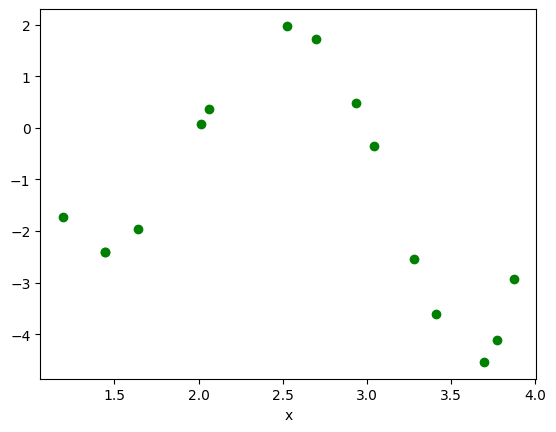

ValueError: cannot reshape array of size 6012 into shape (2,1002)

In [21]:
import time
import tracemalloc


def calc_y(x, coeffs):
    return sum([coeffs[i] * (x ** i) for i in range(len(coeffs))])


def generate_data(coeffs, num_of_points, x_range_left, x_range_right, deviation):
    X = [random.uniform(x_range_left, x_range_right) for _ in range(num_of_points)]
    Y = [calc_y(X[i], coeffs) + random.uniform(-deviation, +deviation) for i in range(num_of_points)]

    return [np.array(X), np.array(Y)]


def gen_linear_reg(coeffs, num_of_points, x_range_left, x_range_right, deviation, calculated_lambdas):
    T = np.array(calculated_lambdas)
    points = generate_data(coeffs, num_of_points, x_range_left, x_range_right, deviation)
    X, Y = points
    W = np.zeros(len(coeffs))
    return LinearRegression(T, W, X, Y)


def test_universal(lin_reg, lr, method, lrs):
    # 1 - mem, 2 - steps, 3 - time, 4 - sqrs
    res_univ = []

    start = time.time()
    tracemalloc.start()
    steps = sgd_handler(lin_reg, lr, method, lrs=lrs, store_points=True)
    res_univ.append(tracemalloc.get_traced_memory())
    tracemalloc.stop()
    end = time.time()

    res_univ.append(steps)
    res_univ.append(end - start)
    res_univ.append(lin_reg.loss(lin_reg.W) / len(lin_reg.X))

    return res_univ


power_lambda = lambda power: lambda x: x ** power

first_tests_val = gen_linear_reg(
    coeffs=[24., -26., -15., 25., -9., 1.],
    num_of_points=15,
    x_range_left=1.,
    x_range_right=4.,
    deviation=0.,
    calculated_lambdas=np.array([power_lambda(5 - i) for i in range(6)])
)

test_results = {}


def tests():
    for method in Methods:
        for regularization in Regularization:
            for lr in LearningRate:
                for lrs in LearningRateScheduling:
                    cur_lr = None
                    if lr == LearningRate.Const:
                        cur_lr = lambda x: 0.001
                    elif lr == LearningRate.Dichotomy:
                        cur_lr = lr_dichotomy(0.001, 0.0001)
                    info = 'Method: {} | Regularization: {} | Learning Rate: {} | Learning Rate Scheduling: {}'\
                        .format(method.name, regularization.name, lr.name, lrs.name)

                    first_tests_val.W = np.zeros(len(first_tests_val.W))
                    first_tests_val.W_points = [np.copy(first_tests_val.W)]
                    first_tests_val.loss_values = [first_tests_val.loss(first_tests_val.W)]
                    results = test_universal(first_tests_val, cur_lr, method, lrs)

                    print(info)
                    visualise_points(first_tests_val)
                    test_results[info] = results


tests()

for key in test_results:
    print(str(key) + " -> ")
    print('\n'.join(str(val) for val in test_results[key]))
    print()

In [ ]:
# n = 3
#
# current_t = np.array(np.array([power_lambda(n - 1 - i) for i in range(n)]))
# current_w = np.zeros(n)
# current_x = np.array([1., 2., 9., -2., -10.])
# current_y = np.array([1., 2., 9., -2., 5])
#
# for method in Methods:
#     for regularization in Regularization:
#         for lr in LearningRate:
#             linear_reg_const = LinearRegression(
#                 current_t, current_w, current_x, current_y, regularization
#             )
#             print(str(method) + " " + str(regularization) + " " + str(lr))
#             if lr == LearningRate.Const:
#                 sgd_handler(linear_reg_const, lambda x: 0.01, method)
#             elif lr == LearningRate.Dichotomy:
#                 sgd_handler(linear_reg_const, lr_dichotomy(0.001, 0.0001), method)
#             visualise_points(linear_reg_const)
#             visualise_loss(np.array(linear_reg_const.loss_values))
#             current_w = np.zeros(n)
#             print("\n\n")